In [1]:
%pip install ray --quiet
%pip install lz4 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# create a shortcut to shared folder and run this
%cd /content/drive/MyDrive/A3_PPO

/content/drive/MyDrive/A3_PPO


In [4]:
import numpy as np
from tqdm import tqdm
import ray
import ray.rllib.agents.ppo as ppo
# from ray.tune.logger import pretty_print
import matplotlib.pyplot as plt
#
from main.continuous import FloorCleaning
from main.robot import Robot
from main.parsing import parse_config
from main.square import get_area
from evaluation import get_cleaning_efficiency

**Use this code in Chrome terminal (Ctrl+shift+i) to prevent session timeout :**

function ClickConnect(){
console.log("Working"); 
document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
}
var clicker = setInterval(ClickConnect,60000);

**And the following code when you need to stop:**

clearInterval(clicker);

(RolloutWorker pid=2846) 2022-06-19 10:02:49,294	WARNING env.py:136 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=2849) 2022-06-19 10:02:49,293	WARNING env.py:136 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-06-19 10:02:52,199	WARNING util.py:65 -- Install gputil for GPU system monitoring.
100%|██████████| 1/1 [00:09<00:00,  9.16s/it]


checkpoint saved at checkpoints/checkpoint00001_099/checkpoint_000001/checkpoint-1


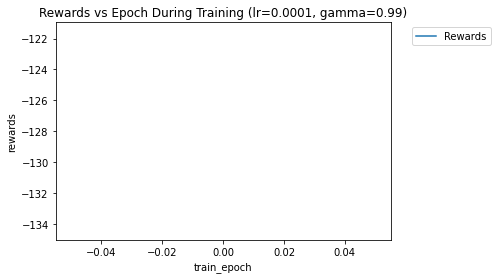

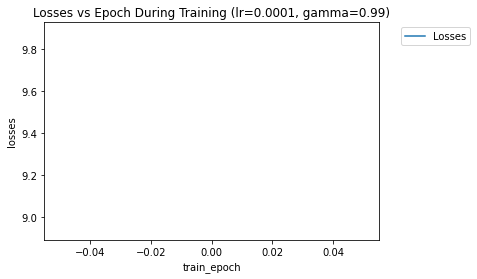

2022-06-19 10:03:01,827	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: checkpoints/checkpoint00001_099/checkpoint_000001/checkpoint-1
2022-06-19 10:03:01,829	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 9.153597593307495, '_episodes_total': 26}
 10%|█         | 1/10 [00:00<00:05,  1.56it/s]

Epoch: 0 -- Reward: 791.0 -- Cleaning %: [11.29032258]


 20%|██        | 2/10 [00:01<00:05,  1.55it/s]

Epoch: 1 -- Reward: 1005.0 -- Cleaning %: [8.87096774]


 30%|███       | 3/10 [00:01<00:04,  1.53it/s]

Epoch: 2 -- Reward: 966.0 -- Cleaning %: [6.4516129]


 40%|████      | 4/10 [00:02<00:03,  1.66it/s]

Epoch: 3 -- Reward: 577.0 -- Cleaning %: [8.87096774]


 50%|█████     | 5/10 [00:03<00:02,  1.69it/s]

Epoch: 4 -- Reward: 859.0 -- Cleaning %: [8.87096774]


 60%|██████    | 6/10 [00:03<00:02,  1.67it/s]

Epoch: 5 -- Reward: 842.0 -- Cleaning %: [8.06451613]


 70%|███████   | 7/10 [00:04<00:01,  1.74it/s]

Epoch: 6 -- Reward: 738.0 -- Cleaning %: [8.06451613]


 80%|████████  | 8/10 [00:04<00:01,  1.77it/s]

Epoch: 7 -- Reward: 818.0 -- Cleaning %: [5.64516129]


 90%|█████████ | 9/10 [00:05<00:00,  1.73it/s]

Epoch: 8 -- Reward: 941.0 -- Cleaning %: [7.25806452]


100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

Epoch: 9 -- Reward: 792.0 -- Cleaning %: [8.87096774]
[791.0, 1005.0, 966.0, 577.0, 859.0, 842.0, 738.0, 818.0, 941.0, 792.0]
[array([11.29032258]), array([8.87096774]), array([6.4516129]), array([8.87096774]), array([8.87096774]), array([8.06451613]), array([8.06451613]), array([5.64516129]), array([7.25806452]), array([8.87096774])]


In [6]:
# parent_path = Path(".").resolve().parent
grid = parse_config("grids/example.grid")
robot = Robot(init_position=(0, 8))
ray.shutdown()
ray.init()
config = ppo.DEFAULT_CONFIG.copy()
config["num_gpus"] = 1
config["num_workers"] = 2
config["env_config"] = {"robot": robot, "grid": grid}
config["recreate_failed_workers"] = True
config["gamma"] = 0.99
config["lr"] = 0.0001

PPO_trainer = ppo.PPOTrainer(env=FloorCleaning, config=config)

checkpoint_path = f"checkpoints/checkpoint{str(config['lr']).replace('.','')}_{str(config['gamma']).replace('.','')}"
train_losses = []
train_rewards = []
# trainer.train()
for i in tqdm(range(300)):
    # Perform one iteration of training the policy with PPO
    result = PPO_trainer.train()
    # print(result))
    train_rewards.append(result["episode_reward_mean"])
    train_losses.append(result["info"]["learner"]["default_policy"]["learner_stats"]["total_loss"])

checkpoint_path = PPO_trainer.save(checkpoint_dir=checkpoint_path)
print("checkpoint saved at", checkpoint_path)
plt.xlabel('train_epoch')
plt.ylabel('rewards')
plt.plot(train_rewards, label='Rewards')
plt.title(f"Rewards vs Epoch During Training (lr={config['lr']}, gamma={config['gamma']})")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

plt.xlabel('train_epoch')
plt.ylabel('losses')
plt.plot(train_losses, label='Losses')
plt.title(f"Losses vs Epoch During Training (lr={config['lr']}, gamma={config['gamma']})")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

np.savetxt(f"train_rewards{str(config['lr']).replace('.','')}_{str(config['gamma']).replace('.','')}.csv", 
           train_rewards,
           delimiter =", ", 
           fmt ='% s')

np.savetxt(f"train_losses{str(config['lr']).replace('.','')}_{str(config['gamma']).replace('.','')}.csv", 
           train_losses,
           delimiter =", ", 
           fmt ='% s')

#PPO_trainer.restore(f'{checkpoint_path}/checkpoint_000300/checkpoint-300')
PPO_trainer.restore(checkpoint_path)

test_cleaning = []
test_reward = []

for epoch in tqdm(range(10)):
    env = FloorCleaning(dict(robot=robot, grid=grid))
    obs = env.reset()
    #env.render()
    running_reward = 0.0
    initial_dust_area = sum([get_area(patch) for patch in env.grid.dirt_places]) + \
                        sum([get_area(patch) for patch in env.grid.much_dirt_places]) + sum([get_area(patch) for patch in env.grid.reg_dirt])
    s = 0
    done = False
    while not done:
        move = PPO_trainer.compute_action(obs)
        obs, reward, done, info = env.step(move)
        #env.render()
        #print(f"move: {move/(2*np.pi)*360}, reward: {reward}")
        running_reward += reward
        s += 1

    final_dust_area = sum([get_area(patch) for patch in env.grid.dirt_places]) + \
                      sum([get_area(patch) for patch in env.grid.much_dirt_places]) + sum([get_area(patch) for patch in env.grid.reg_dirt])

    cleaning_area = initial_dust_area - final_dust_area
    cleaning_per = (cleaning_area / initial_dust_area) * 100

    test_reward.append(running_reward)
    test_cleaning.append(cleaning_per)
    print(f"Epoch: {epoch} -- Reward: {running_reward} -- Cleaning %: {cleaning_per}")

print(test_reward)
print(test_cleaning)